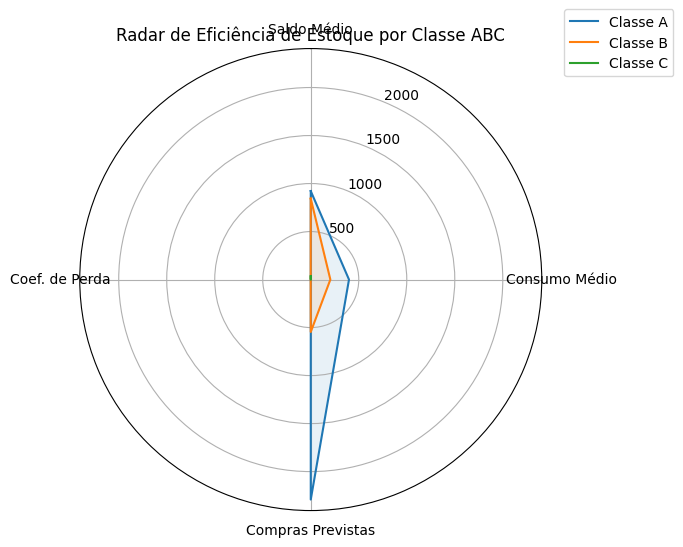

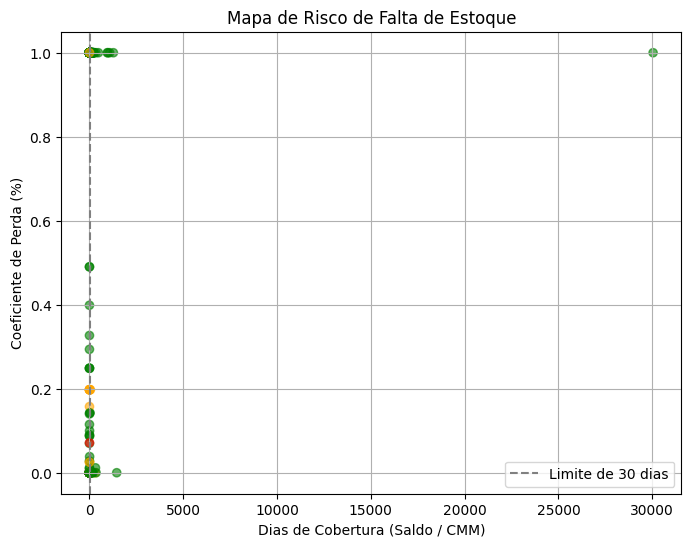

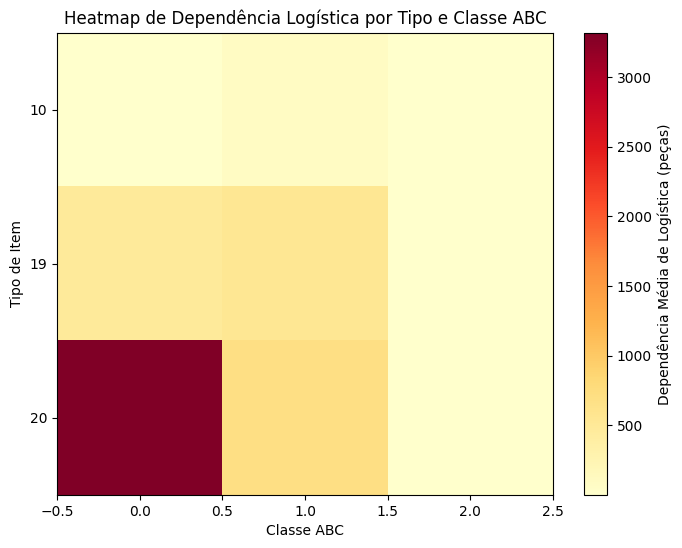

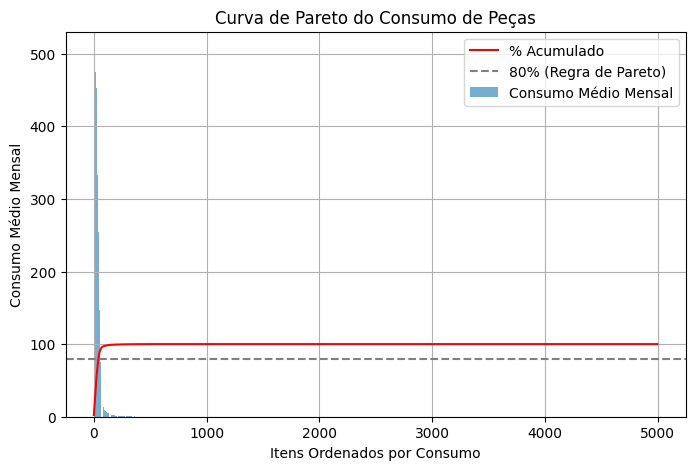

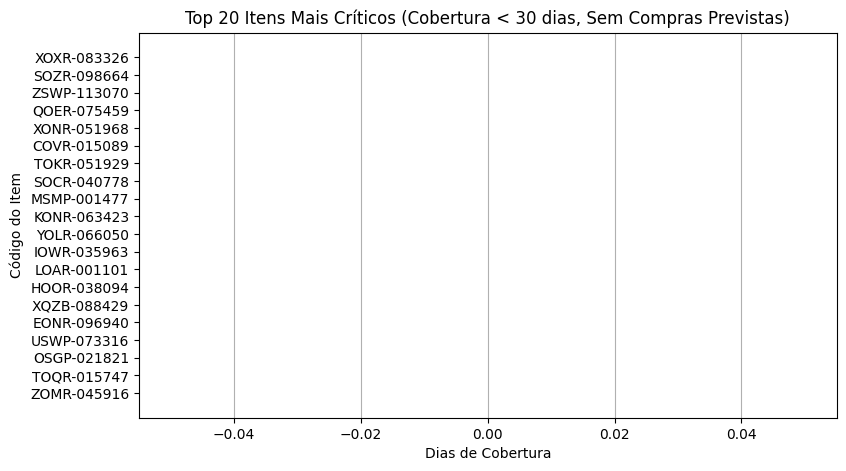

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Leitura dos dados ===
df = pd.read_csv("dados_hackathon.csv", sep=";")

# === Cálculos adicionais ===
df["dias_cobertura"] = df.apply(lambda x: x["saldo_manut"] / x["cmm"] if x["cmm"] > 0 else np.nan, axis=1)
df["dependencia_logistica"] = df[["provid_compras", "transito_manut", "recebimento_esperado"]].sum(axis=1)

# Itens críticos
itens_criticos = df[(df["cmm"] > 0) & (df["dias_cobertura"] < 30) & (df["provid_compras"] == 0)]

# === 1️⃣ Radar de Eficiência de Estoque ===
df_abc = df.groupby("abc")[["saldo_manut", "cmm", "provid_compras", "coef_perda"]].mean().reset_index()
labels = ["Saldo Médio", "Consumo Médio", "Compras Previstas", "Coef. de Perda"]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
for _, row in df_abc.iterrows():
    values = row[["saldo_manut", "cmm", "provid_compras", "coef_perda"]].tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"Classe {row['abc']}")
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar de Eficiência de Estoque por Classe ABC")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()

# === 2️⃣ Mapa de Risco de Falta de Estoque ===
plt.figure(figsize=(8,6))
plt.scatter(df["dias_cobertura"], df["coef_perda"], c=df["abc"].map({"A": "red", "B": "orange", "C": "green"}), alpha=0.6)
plt.axvline(30, color="gray", linestyle="--", label="Limite de 30 dias")
plt.xlabel("Dias de Cobertura (Saldo / CMM)")
plt.ylabel("Coeficiente de Perda (%)")
plt.title("Mapa de Risco de Falta de Estoque")
plt.legend()
plt.grid(True)
plt.show()

# === 3️⃣ Heatmap de Dependência Logística ===
pivot = df.pivot_table(values="dependencia_logistica", index="tipo", columns="abc", aggfunc="mean")
plt.figure(figsize=(8,6))
plt.imshow(pivot, cmap="YlOrRd", aspect="auto")
plt.colorbar(label="Dependência Média de Logística (peças)")
plt.title("Heatmap de Dependência Logística por Tipo e Classe ABC")
plt.xlabel("Classe ABC")
plt.ylabel("Tipo de Item")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.show()

# === 4️⃣ Curva de Pareto de Consumo ===
df_sorted = df.sort_values("cmm", ascending=False)
df_sorted["acumulado"] = df_sorted["cmm"].cumsum() / df_sorted["cmm"].sum() * 100

plt.figure(figsize=(8,5))
plt.bar(range(len(df_sorted)), df_sorted["cmm"], alpha=0.6, label="Consumo Médio Mensal")
plt.plot(range(len(df_sorted)), df_sorted["acumulado"], color="red", label="% Acumulado")
plt.axhline(80, color="gray", linestyle="--", label="80% (Regra de Pareto)")
plt.title("Curva de Pareto do Consumo de Peças")
plt.xlabel("Itens Ordenados por Consumo")
plt.ylabel("Consumo Médio Mensal")
plt.legend()
plt.grid(True)
plt.show()

# === 5️⃣ Ranking de Itens Mais Críticos ===
top_criticos = itens_criticos.sort_values("dias_cobertura").head(20)
plt.figure(figsize=(9,5))
plt.barh(top_criticos["codigo"], top_criticos["dias_cobertura"], color="crimson")
plt.title("Top 20 Itens Mais Críticos (Cobertura < 30 dias, Sem Compras Previstas)")
plt.xlabel("Dias de Cobertura")
plt.ylabel("Código do Item")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.show()


In [ ]:
# ============================================================================
# TREINAMENTO DO MODELO DE PREVISÃO DE REPOSIÇÃO DE ESTOQUE
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("INICIANDO TREINAMENTO DO MODELO")
print("="*70)

# ============================================================================
# 1) CARREGA DADOS
# ============================================================================
print("\n[1/6] Carregando dados...")
df = pd.read_csv('dados_hackathon.csv', sep=';')
df.columns = [c.strip() for c in df.columns]

# Converte colunas numéricas
obj_cols = ['codigo','abc']
for c in df.columns:
    if c not in obj_cols:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(',','.'), errors='coerce')

print(f"✓ Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas")

# ============================================================================
# 2) ENGENHARIA DE FEATURES
# ============================================================================
print("\n[2/6] Criando features...")

# Saldo de peças boas (disponíveis)
cols_boas = ['saldo_manut','provid_compras','recebimento_esperado','transito_manut',
             'stage_manut','recepcao_manut','pendente_ri']
for c in cols_boas:
    if c not in df.columns:
        df[c] = 0
df['saldo_boas'] = df[cols_boas].fillna(0).sum(axis=1)

# Peças em teste
cols_teste = ['pecas_teste','pecas_teste_kit']
for c in cols_teste:
    if c not in df.columns:
        df[c] = 0
df['saldo_teste'] = df[cols_teste].fillna(0).sum(axis=1)

# Peças para reparo (recuperáveis)
cols_reparo = ['fornecedor_reparo','laboratorio','wr','wrcr','stage_wr']
for c in cols_reparo:
    if c not in df.columns:
        df[c] = 0
recuperacao_perc = (1 - df['coef_perda'].fillna(0).clip(0,1))
df['saldo_reparo_recuperavel'] = df[cols_reparo].fillna(0).sum(axis=1) * recuperacao_perc

# Saldo total por tipologia
df['saldo_total'] = np.where(df['tipo'].isin([10,19]),
                              df['saldo_boas'] + df['saldo_teste'] + df['saldo_reparo_recuperavel'],
                              df['saldo_boas'])

# Estoque de Segurança (ES) - padrão mínimo
def calc_es(row):
    cmm = row.get('cmm', 0.0) or 0.0
    abc = str(row.get('abc','')).strip().upper()
    tipo = int(row.get('tipo', 20) or 20)

    # Regras de negócio para estoque mínimo
    if abc == 'A' and tipo in (10,19):
        return 4 * cmm
    if abc == 'A' and tipo == 20:
        return 1.5 * cmm
    if abc in ('B','C') and tipo in (10,19):
        return 5 * cmm
    if abc in ('B','C') and tipo == 20:
        return 2.5 * cmm
    return 3 * cmm

df['ES'] = df.apply(calc_es, axis=1)

# Fator de Ajuste (FA) - estoque alvo considerando perdas
cmm = df['cmm'].fillna(0)
coef_perda = df['coef_perda'].fillna(0).clip(0,1)
df['FA'] = np.where(df['tipo'].isin([10,19]),
                    df['ES'] + 4*cmm*coef_perda,
                    df['ES'] + 4*cmm)

# TARGET: Quantidade a Adquirir (QA)
df['QA'] = (df['FA'] - df['saldo_total']).clip(lower=0)

# Features adicionais
df['backlog_total'] = df[['pendente_ri','recepcao_manut','transito_manut','wr','wrcr','stage_wr']].fillna(0).sum(axis=1)
df['taxa_backlog'] = df['backlog_total'] / (df['saldo_total'] + 1)
df['razao_saldo_cmm'] = df['saldo_total'] / (df['cmm'] + 0.01)
df['razao_provid_cmm'] = df['provid_compras'] / (df['cmm'] + 0.01)
df['item_critico'] = (df['cmm'] > df['cmm'].quantile(0.75)).astype(int)
df['alto_risco_perda'] = (df['coef_perda'] >= 0.5).astype(int)
df['abc_encoded'] = df['abc'].map({'A':3, 'B':2, 'C':1}).fillna(1)
df['estoque_pct'] = (df['saldo_total'] / (df['FA'] + 0.01)) * 100
df['cobertura_dias'] = (df['saldo_total'] / (df['cmm'] + 0.01)) * 30

print(f"✓ Features criadas")

# ============================================================================
# 3) PREPARAÇÃO DOS DADOS
# ============================================================================
print("\n[3/6] Preparando dados para treinamento...")

feature_cols = [
    'tipo', 'cmm', 'coef_perda', 'saldo_boas', 'saldo_teste',
    'saldo_reparo_recuperavel', 'saldo_total', 'ES', 'FA',
    'provid_compras', 'backlog_total', 'taxa_backlog',
    'razao_saldo_cmm', 'razao_provid_cmm', 'item_critico',
    'alto_risco_perda', 'abc_encoded', 'estoque_pct', 'cobertura_dias'
]

df_model = df[feature_cols + ['QA', 'codigo', 'abc']].copy()
df_model = df_model.dropna()

X = df_model[feature_cols]
y = df_model['QA']

print(f"✓ Dataset preparado: {X.shape[0]} linhas, {X.shape[1]} features")
print(f"\nDistribuição do target (QA - Quantidade a Adquirir):")
print(y.describe())

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✓ Split realizado:")
print(f"  - Treino: {X_train.shape[0]} amostras")
print(f"  - Teste:  {X_test.shape[0]} amostras")

# ============================================================================
# 4) TREINAMENTO DOS MODELOS
# ============================================================================
print("\n[4/6] Treinando modelos...")

# Modelo 1: Random Forest
print("\n  → Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"    MAE:  {mae_rf:.2f}")
print(f"    RMSE: {rmse_rf:.2f}")
print(f"    R²:   {r2_rf:.4f}")

# Modelo 2: Gradient Boosting
print("\n  → Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"    MAE:  {mae_gb:.2f}")
print(f"    RMSE: {rmse_gb:.2f}")
print(f"    R²:   {r2_gb:.4f}")

# Seleciona o melhor modelo
best_model = rf_model if r2_rf >= r2_gb else gb_model
model_name = "RandomForest" if r2_rf >= r2_gb else "GradientBoosting"
best_r2 = r2_rf if r2_rf >= r2_gb else r2_gb
best_mae = mae_rf if r2_rf >= r2_gb else mae_gb
best_rmse = rmse_rf if r2_rf >= r2_gb else rmse_gb

print(f"\n✓ Melhor modelo: {model_name}")

# ============================================================================
# 5) ANÁLISE DE IMPORTÂNCIA DAS FEATURES
# ============================================================================
print("\n[5/6] Analisando importância das features...")

importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features mais importantes:")
print(importances.head(10).to_string(index=False))

# ============================================================================
# 6) SALVA O MODELO TREINADO
# ============================================================================
print("\n[6/6] Salvando modelo treinado...")

# Salva o modelo
joblib.dump(best_model, 'modelo_reposicao.pkl')

# Salva as features usadas
with open('features.txt', 'w') as f:
    f.write('\n'.join(feature_cols))

# Salva metadados do treinamento
metadata = {
    'modelo': model_name,
    'r2_score': best_r2,
    'mae': best_mae,
    'rmse': best_rmse,
    'n_features': len(feature_cols),
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test)
}

import json
with open('modelo_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Modelo salvo: modelo_reposicao.pkl")
print(f"✓ Features salvas: features.txt")
print(f"✓ Metadados salvos: modelo_metadata.json")

# ============================================================================
# RESUMO DO TREINAMENTO
# ============================================================================
print("\n" + "="*70)
print("TREINAMENTO CONCLUÍDO COM SUCESSO!")
print("="*70)

print(f"\n📊 MÉTRICAS DO MODELO:")
print(f"  • Modelo: {model_name}")
print(f"  • R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)")
print(f"  • MAE: {best_mae:.2f} peças")
print(f"  • RMSE: {best_rmse:.2f} peças")

print(f"\n🎯 O QUE O MODELO APRENDEU:")
print(f"  • Quantidade padrão no estoque: ES (Estoque de Segurança)")
print(f"  • Uso médio mensal: CMM (Consumo Médio Mensal)")
print(f"  • Quando repor: Quando saldo_total < FA (Fator de Ajuste)")
print(f"  • Quanto repor: QA = FA - saldo_total")

print(f"\n📁 ARQUIVOS GERADOS:")
print(f"  1. modelo_reposicao.pkl - Modelo treinado")
print(f"  2. features.txt - Lista de features")
print(f"  3. modelo_metadata.json - Metadados do treinamento")

print(f"\n💡 PRÓXIMO PASSO:")
print(f"  Use o modelo treinado para fazer predições em novos dados")
print(f"  ou execute o script de monitoramento contínuo.")

print("\n" + "="*70)


INICIANDO TREINAMENTO DO MODELO

[1/6] Carregando dados...
✓ Dataset carregado: 5000 linhas, 19 colunas

[2/6] Criando features...
✓ Features criadas

[3/6] Preparando dados para treinamento...
✓ Dataset preparado: 5000 linhas, 19 features

Distribuição do target (QA - Quantidade a Adquirir):
count    5000.000000
mean       10.711083
std       141.233172
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3158.500000
Name: QA, dtype: float64

✓ Split realizado:
  - Treino: 4000 amostras
  - Teste:  1000 amostras

[4/6] Treinando modelos...

  → Random Forest Regressor...
    MAE:  3.74
    RMSE: 56.76
    R²:   0.8269

  → Gradient Boosting Regressor...
    MAE:  3.90
    RMSE: 71.60
    R²:   0.7247

✓ Melhor modelo: RandomForest

[5/6] Analisando importância das features...

Top 10 features mais importantes:
        feature  importance
             ES    0.398413
             FA    0.249726
            cmm    0.109153
razao_saldo_cmm    0.0644

In [1]:
# ======================================================================
# PREVER QA COM O MODELO TREINADO (USANDO dados_teste_com_imagens.csv)
# ======================================================================

import pandas as pd
import numpy as np
import joblib
import json

# 1) Carrega modelo e metadados
modelo = joblib.load('modelo_reposicao.pkl')
with open('features.txt', 'r') as f:
    feature_cols_treino = [line.strip() for line in f.readlines()]

# 2) Carrega CSV de teste
df = pd.read_csv('dados_teste_com_imagens.csv', sep=';')
df.columns = [c.strip() for c in df.columns]

# 3) Conversão numérica onde couber
obj_cols = {'codigo','abc','img_url','descricao'}
for c in df.columns:
    if c not in obj_cols:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(',','.'), errors='coerce')

# 4) Garante colunas-base mínimas (caso o CSV tenha vindo sem alguma)
colunas_base = [
    'saldo_manut','provid_compras','recebimento_esperado','transito_manut',
    'stage_manut','recepcao_manut','pendente_ri','pecas_teste','pecas_teste_kit',
    'fornecedor_reparo','laboratorio','wr','wrcr','stage_wr','tipo','cmm','coef_perda','abc'
]
for col in colunas_base:
    if col not in df.columns:
        df[col] = 0

# 5) Recria as mesmas features derivadas do treino (essencial)
cols_boas = ['saldo_manut','provid_compras','recebimento_esperado','transito_manut','stage_manut','recepcao_manut','pendente_ri']
df['saldo_boas'] = df[cols_boas].fillna(0).sum(axis=1)

cols_teste = ['pecas_teste','pecas_teste_kit']
df['saldo_teste'] = df[cols_teste].fillna(0).sum(axis=1)

cols_reparo = ['fornecedor_reparo','laboratorio','wr','wrcr','stage_wr']
recuperacao_perc = (1 - df['coef_perda'].fillna(0).clip(0,1))
df['saldo_reparo_recuperavel'] = df[cols_reparo].fillna(0).sum(axis=1) * recuperacao_perc

df['saldo_total'] = np.where(
    df['tipo'].isin([10,19]),
    df['saldo_boas'] + df['saldo_teste'] + df['saldo_reparo_recuperavel'],
    df['saldo_boas']
)

def calc_es(row):
    cmm = row.get('cmm', 0.0) or 0.0
    abc = str(row.get('abc','')).strip().upper()
    tipo = int(row.get('tipo', 20) or 20)
    if abc == 'A' and tipo in (10,19):
        return 4*cmm
    if abc == 'A' and tipo == 20:
        return 1.5*cmm
    if abc in ('B','C') and tipo in (10,19):
        return 5*cmm
    if abc in ('B','C') and tipo == 20:
        return 2.5*cmm
    return 3*cmm

df['ES'] = df.apply(calc_es, axis=1)

cmm = df['cmm'].fillna(0)
coef_perda = df['coef_perda'].fillna(0).clip(0,1)
df['FA'] = np.where(
    df['tipo'].isin([10,19]),
    df['ES'] + 4*cmm*coef_perda,
    df['ES'] + 4*cmm
)

df['QA_real'] = (df['FA'] - df['saldo_total']).clip(lower=0)

df['backlog_total'] = df[['pendente_ri','recepcao_manut','transito_manut','wr','wrcr','stage_wr']].fillna(0).sum(axis=1)
df['taxa_backlog'] = df['backlog_total'] / (df['saldo_total'] + 1)
df['razao_saldo_cmm'] = df['saldo_total'] / (df['cmm'] + 0.01)
df['razao_provid_cmm'] = df['provid_compras'] / (df['cmm'] + 0.01)
df['item_critico'] = (df['cmm'] > df['cmm'].quantile(0.75)).astype(int)
df['alto_risco_perda'] = (df['coef_perda'] >= 0.5).astype(int)
df['abc_encoded'] = df['abc'].map({'A':3, 'B':2, 'C':1}).fillna(1)
df['estoque_pct'] = (df['saldo_total'] / (df['FA'] + 0.01)) * 100
df['cobertura_dias'] = (df['saldo_total'] / (df['cmm'] + 0.01)) * 30

# 6) Prepara X exatamente com as features do treino
for feat in feature_cols_treino:
    if feat not in df.columns:
        df[feat] = 0

X = df[feature_cols_treino].copy().fillna(0)

# 7) Prediz e imprime um resumo simples
df['QA_previsto'] = modelo.predict(X).clip(min=0)

# Saída resumida
print("====== PREVISÃO CONCLUÍDA ======")
print(f"Itens: {len(df)}")
print(f"Total QA_previsto: {df['QA_previsto'].sum():.0f}")
print("Top 10 por QA_previsto:")
cols_show = ['codigo', 'img_url', 'descricao'] if 'img_url' in df.columns and 'descricao' in df.columns else ['codigo']
cols_show += ['abc','tipo','cmm','saldo_total','FA','QA_previsto']
print(df.sort_values('QA_previsto', ascending=False)[cols_show].head(10).to_string(index=False))

FileNotFoundError: [Errno 2] No such file or directory: 'modelo_reposicao.pkl'